# Predicting Starcraft 2 players
[Kaggle Starcraft II Prediction Challenge](https://www.kaggle.com/c/insa-5if-2018)

## Initialisation
We will use Python3 with [Numpy](http://www.numpy.org/) for linear algebra, [Pandas](https://pandas.pydata.org/) for data processing and CSV files I/O, and [scikit-learn](https://scikit-learn.org/stable/) for predictions. The environment is defined by the [Kaggle Python docker image](https://github.com/kaggle/docker-python).

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
import os
pd.set_option('display.max_colwidth', 200)

## Reading data
Let's define some functions to read data from the CSV files. We are storing an array of actions for each line.

In [2]:
def read_train(file):
    ids = []
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            battlenet_id, race, actions = line_data[0],line_data[1],line_data[2:]
            ids.append(battlenet_id)
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    series = pd.Series(ids)
    return df, series

def read_test(file):
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            race, actions = line_data[0],line_data[1:]
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    return df
        

Input data files are available in the `../input/` directory.
Any results written to the current directory are saved as output.

In [3]:
folder = '../'
train_data, train_ids = read_train(folder + 'TRAIN.CSV')
train_data.head()

,race,actions
0,Protoss,"Base, s, s, s, s, s, t5, Base, s, hotkey30, hotkey00, t10, t15, t20, t25, t30, t35, s, hotkey32, s, hotkey32, s, hotkey32, s, t40, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, t45, hotkey32..."
1,Protoss,"s, Base, s, s, Base, s, s, Base, s, t5, hotkey30, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t10, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t15, s, hot..."
2,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5, t10, t15, s, hotkey32, s, hotkey32, s, hotkey32, s, t20, hotkey32, s, s, hotkey32, s, hotkey32, t25, s, hotkey32, s, hotkey32, s, hotkey32, s, hotke..."
3,Protoss,"Base, s, s, Base, s, s, s, t5, Base, s, hotkey30, s, hotkey32, s, hotkey32, t10, s, hotkey32, s, hotkey32, t15, s, hotkey32, s, t20, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t25, s, hotkey..."
4,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5, t10, t15, s, hotkey32, s, hotkey32, s, hotkey32, t20, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, t25, hotkey32, t30, s, hot..."


In [4]:
train_ids.head()

0       http://eu.battle.net/sc2/en/profile/4234852/1/First/
1    http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/
2       http://eu.battle.net/sc2/en/profile/4234852/1/First/
3    http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/
4       http://eu.battle.net/sc2/en/profile/4234852/1/First/
dtype: object

In [5]:
test_data = read_test(folder + 'TEST.CSV')
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s, hotkey90, t5, hotkey02, s, hotkey02, hotkey62, hotkey02, s, hotkey02, hotkey62, hotkey02, hotkey62, s, hotkey02, hotkey62, s, hotkey62, hotkey02, ho..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t10, s, hotke..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotkey60, hotkey40, hotkey80, hotkey70, s, hotkey62, s, hotkey62, t5, s, hotkey62, s, hotkey20, hotkey62, hotkey22, hotkey62, s, hotkey62, s, hotkey62, hot..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, hotkey22, hotkey42, s, hotkey42, s, t15, s, s, s, hotkey42, s, hotkey42, hotkey22, hotkey42, hotkey22, hotkey42, t20, s, hotkey42, s, hotkey42, s, hotke..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, hotkey40, s, t10, hotkey52, t15, s, t20, hotkey52, t25, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, hotkey52, s, h..."


## First look at the data

### Race repartition

In [6]:
races = train_data['race'].value_counts()
print(races)
plt = races.plot.bar()

Protoss    1210
Zerg       1061
Terran      781
Name: race, dtype: int64


### Number of games by player

In [7]:
ids = train_ids.value_counts()
print(ids.describe())

count    200.00000
mean      15.26000
std       10.41464
min        4.00000
25%        7.00000
50%       12.00000
75%       20.00000
max       58.00000
dtype: float64


### List of actions (hotkeys)

In [8]:
def find_unique_actions(df):
    unique_actions = set()
    actions = df['actions']
    for action in actions:
        for a in action.split(','):
            a = a.strip()
            if a!='' and a[0]!='t':
                unique_actions.add(a)
    return unique_actions

unique_hotkeys = sorted(list(find_unique_actions(train_data)))
print(unique_hotkeys)

keys = list(set([hotkey[:len(hotkey)-1] for hotkey in unique_hotkeys if 'hotkey' in hotkey]))
print(keys)
    

['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']
['hotkey7', 'hotkey8', 'hotkey9', 'hotkey5', 'hotkey1', 'hotkey4', 'hotkey3', 'hotkey6', 'hotkey0', 'hotkey2']


## Defining features
We are defining features as the race and the number of clicks on the hotkeys in the first 10 seconds. We have 
Let's try this approach by writing a function to generate those features.

We use Dummy variables to convert the race string into integers values.

In [9]:
hotkey_columns = ['first_hotkey','second_hotkey','third_hotkey','fourth_hotkey','fifth_hotkey','sixth_hotkey','seventh_hotkey','eighth_hotkey']

le = preprocessing.LabelEncoder()

def generate_features(df):
    features = []
    hotkeys = unique_hotkeys
    set_hotkeys = set(hotkeys)
    for index, row in df.iterrows():
        first_hotkeys = []
        race = row["race"]
        actions = row["actions"]
        hotkeys_count = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t60 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t90 = {hotkey:0 for hotkey in hotkeys}
        t60 = False
        t90 = False
        keys_count = {key:0 for key in keys}
        for action in actions.split(','):
            action = action.strip()
            if action in set_hotkeys:
                hotkeys_count[action]+=1
                if not t60:
                    hotkeys_count_t60[action]+=1
                elif not t90:
                    hotkeys_count_t90[action]+=1
            if 'hotkey' in action:
                keys_count[action[:len(action)-1]]+=1
            if len(first_hotkeys)<len(hotkey_columns) and 'hotkey' in action:
                first_hotkeys.append(action)
            if 't60' in action:
                t60 = True
            elif 't90' in action:
                t90 = True
        while len(first_hotkeys)<len(hotkey_columns):
            first_hotkeys.append('None')
        current = [race, *[hotkeys_count[hotkey] for hotkey in hotkeys],*[hotkeys_count_t60[hotkey] for hotkey in hotkeys],*[hotkeys_count_t90[hotkey] for hotkey in hotkeys], *[keys_count[key] for key in keys], *first_hotkeys]
        features.append(current)
    new_df = pd.DataFrame(features, columns=['race', *hotkeys,*[hotkey+'_t60' for hotkey in hotkeys],*[hotkey+'_t90' for hotkey in hotkeys], *keys, *hotkey_columns])
    return new_df

In [10]:
train_features = generate_features(train_data)
train_features = pd.get_dummies(train_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    train_features[col] = le.fit_transform(train_features[col]) 
train_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,66,5,5,0,41,63,0,350,37,0,...,1,10,9,10,10,9,9,1,0,0
1,12,0,2,0,83,65,3,448,15,0,...,11,10,9,10,10,9,9,1,0,0
2,47,3,3,0,18,17,0,130,9,0,...,1,10,9,10,10,9,9,1,0,0
3,21,0,2,0,39,32,1,259,14,0,...,11,10,9,10,10,9,9,1,0,0
4,2,0,1,0,0,10,0,52,6,0,...,1,10,9,10,10,9,9,1,0,0


In [11]:
test_features = generate_features(test_data)
test_features = pd.get_dummies(test_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    test_features[col] = le.fit_transform(test_features[col]) 

'''
# Get missing columns in the training test
missing_cols = set( train_features.columns ) - set( test_features.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_features[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_features = test_features[train_features.columns]
'''

test_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,19,3,14,0,847,7,31,352,10,0,...,15,1,21,3,2,16,3,0,0,1
1,0,0,2,0,33,14,0,336,31,0,...,1,10,9,9,8,9,9,0,1,0
2,20,0,1,0,0,10,0,479,53,0,...,9,15,10,20,16,16,16,1,0,0
3,17,2,0,0,0,68,89,525,13,6,...,11,7,12,11,10,11,7,0,0,1
4,21,0,3,0,0,4,7,74,8,0,...,9,11,14,14,12,13,14,1,0,0


## Predicting players

### Helper functions to save and check csv for submissions

In [12]:
def read_csv_head(path):
    with open(path, 'r') as f:
        c = 0
        for line in f:
            print(line)
            c+=1
            if c==10:
                break

def convert(output):
    output_df = pd.DataFrame(output, columns=['prediction'])
    output_df.index = range(1,len(output_df)+1)
    output_df.index.name = 'RowId'
    return output_df

def save(output_df, name):
    output_df.to_csv('./out_'+name+'.csv')

In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_ids, test_size=0.30, random_state=42)
target_names = train_ids.unique()

### First approach: Logistic regression

In [14]:
classifier = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.8842794759825328

In [15]:
classifier = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
classifier.fit(train_features,train_ids)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
predicted_ids_lr = classifier.predict(test_features)
predicted_ids_lr_df = convert(predicted_ids_lr)
save(predicted_ids_lr_df, 'logisticregression')
predicted_ids_lr_df.head()

,prediction
RowId,
1,http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
2,http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://eu.battle.net/sc2/en/profile/950504/1/Grubby/


### Second approach: Decision Tree

In [17]:
classifier = DecisionTreeClassifier(min_samples_split=20, random_state=99)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.6441048034934498

In [18]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(train_features,train_ids)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [19]:
predicted_ids_dt = dt.predict(test_features)
predicted_ids_dt_df = convert(predicted_ids_dt)
save(predicted_ids_dt_df, 'decisiontree')
predicted_ids_dt_df.head()

,prediction
RowId,
1,http://kr.battle.net/sc2/en/profile/2342766/1/ByuL/
2,http://kr.battle.net/sc2/en/profile/2343852/1/flash/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://eu.battle.net/sc2/en/profile/950504/1/Grubby/


Number of differences between Decision Tree and Logistic Regression

In [20]:
len(predicted_ids_dt_df)-len(set(predicted_ids_dt_df['prediction']).intersection(set(predicted_ids_lr_df['prediction'])))

217

In [21]:
len(predicted_ids_dt_df)

340

### Third approach: Random Forest

In [22]:
classifier = RandomForestClassifier(random_state=13, n_estimators=500)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.9050218340611353

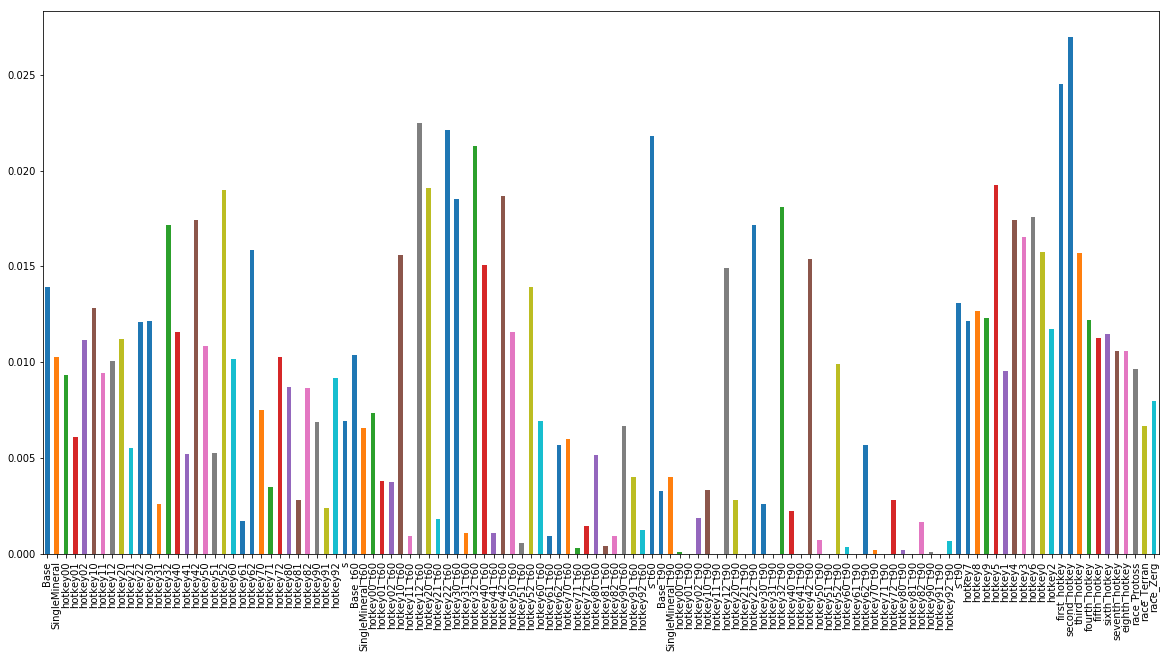

In [23]:
features_importance = pd.Series(classifier.feature_importances_)
features_importance.index = x_train.columns
features_importance.plot.bar(figsize=(20,10))

In [24]:
rf = RandomForestClassifier(random_state=13, n_estimators=500)
rf.fit(train_features,train_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [25]:
predicted_ids_rf = rf.predict(test_features)
predicted_ids_rf_df = convert(predicted_ids_rf)
save(predicted_ids_rf_df, 'randomforest')
predicted_ids_rf_df.head()

,prediction
RowId,
1,http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
2,http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/
3,http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/
4,http://eu.battle.net/sc2/en/profile/250458/1/VortiX/
5,http://eu.battle.net/sc2/en/profile/950504/1/Grubby/


Number of differences between Decision Tree and Random Forest

In [26]:
len(predicted_ids_rf_df)-len(set(predicted_ids_rf_df['prediction']).intersection(set(predicted_ids_dt_df['prediction'])))

210

In [27]:
len(predicted_ids_rf_df)

340